<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборки-и-выделение-признаков." data-toc-modified-id="Разделение-выборки-и-выделение-признаков.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение выборки и выделение признаков.</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBooost" data-toc-modified-id="CatBooost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBooost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

**Задача** - прогноз количества заказов такси на следующий час, чтобы привлекать больше водителей такси в период пиковой нагрузки.

Необходимо провести анализ исторических данных о заказах такси в аэропортах. 

Метрика качества *RMSE*, значение которой должно быть не больше 48.



**Описание данных**
* Количество заказов находится в столбце `num_orders`.

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, metrics, cv

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
# Проверим инфромацию о таблице
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# Проверка на монотонность ряда
taxi.sort_index(inplace=True)
taxi.index.is_monotonic

True

* Есть данные с 1 марта по 31 август 2018 года.
* Ряда монотонный.

In [ ]:
# Пропуски
taxi.isna().sum()

num_orders    0
dtype: int64

* Пропусков нет.

In [ ]:
# Ресэмплируем по одному часу и посчитаем сумму по часу
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Text(0, 0.5, 'Количество заказов такси')

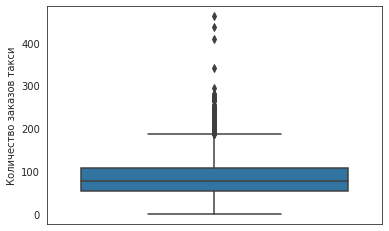

In [ ]:
# Посмотрим на выбросы в данных
sns.set_style('white')
sns.boxplot(y=taxi['num_orders'])
plt.ylabel('Количество заказов такси')

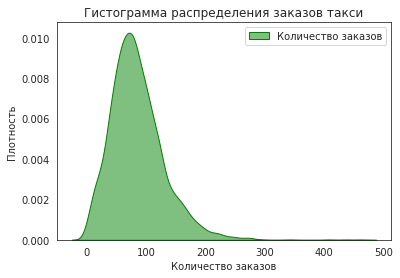

In [ ]:
# Посмотрим на распределение
sns.set_style('white')
sns.kdeplot(taxi['num_orders'], shade=True, color="g", label="Количество заказов", alpha=.5)
plt.title('Гистограмма распределения заказов такси', fontsize=12)
plt.legend(loc='best')
plt.ylabel('Плотность')
plt.xlabel('Количество заказов')
plt.show()


* Данные близки к нормальному распределению. Однако есть выбросы выше 200 заказов. Возможно это выбросы в в определенный период времени.
* Проверим стационарность ряда и изменение дисперсии.

<AxesSubplot:xlabel='datetime'>

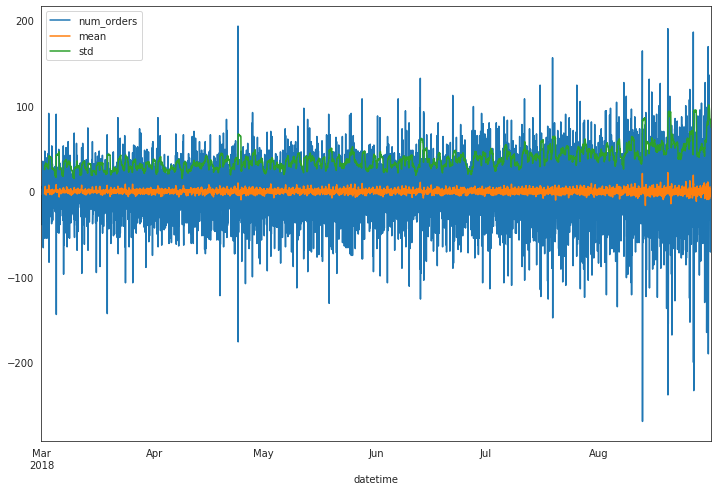

In [ ]:
taxi_stationary = taxi
taxi_stationary = taxi_stationary - taxi_stationary.shift()
taxi_stationary['mean'] = taxi_stationary['num_orders'].rolling(20).mean()
taxi_stationary['std'] = taxi_stationary['num_orders'].rolling(20).std()
taxi_stationary.plot(figsize=(12,8))

* Среднее значение и стандартное отклонение относительно стационарно в течение всего периода, кроме конца августа, где дисперсия растёт.
* Проверим стационарность через тест `Dickey–Fuller`. Если уровень p будет меньше 0,05, то значит ряд стационарный.

In [ ]:
result = adfuller(taxi['num_orders'].values, autolag='AIC')
print(f'Уровень значимости {round(result[1], 3)}')

Уровень значимости0.029


* Отвергаем нулевую гипотезу, что ряд нестационарный.
* Значит по этому ряду можно сделать предсказание без дополнительных преобразований.

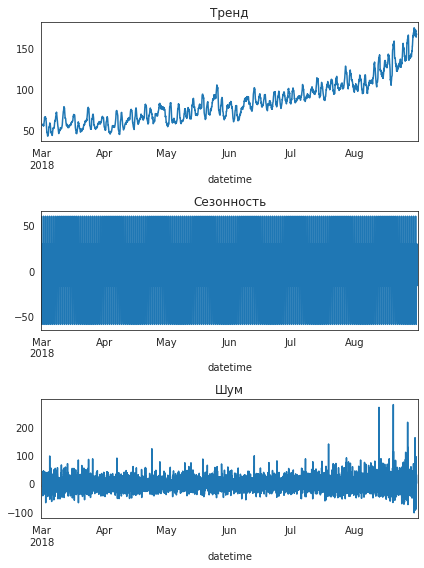

In [ ]:
# Посмотрим на наличие тренда и сезонности
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

* Отмечается явный тренд роста заказов такси в летние периоды.
* Сезонность не отмечается. Однако нужно будет проверить сезонность во время декомпозии.
* Шумы выглядят стационарными. Однако в середине августа отмечается явный рост дисперсии шума.
* Посмотрим на сезонные изменения от часа, дня месяца, дня недели, месяца. 

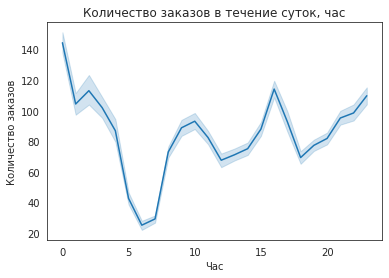

In [ ]:
sns.set_style('white')
sns.lineplot(taxi.index.hour, taxi['num_orders'])
plt.xlabel('Час')
plt.ylabel('Количество заказов')
plt.title('Количество заказов в течение суток, час')
plt.show()

* Заметны явные флуктации по часам. Особенно высокий пик в 12 ночи.
* Значит этот признак может быть важен для построения модели.

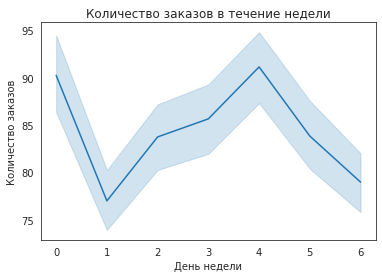

In [ ]:
sns.lineplot(taxi.index.day_of_week, taxi['num_orders'])
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.title('Количество заказов в течение недели')
plt.show()

* В течение недели заметны пики заказов для понедельника и пятницы. Т.е. отмечается не линейная связь.

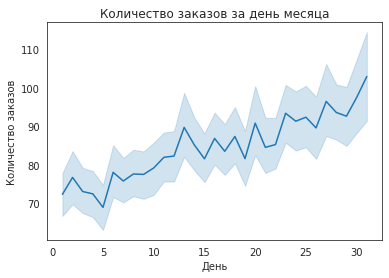

In [ ]:
sns.set_style('white')
sns.lineplot(taxi.index.day, taxi['num_orders'])
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.title('Количество заказов за день месяца')
plt.show()

* Заметен рост заказов по конец месяца. Однако сезонных изменений нет.

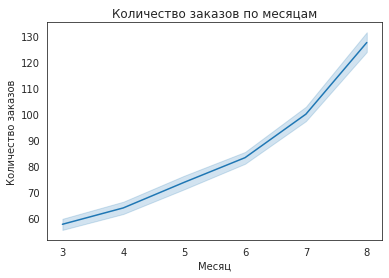

In [ ]:
sns.lineplot(taxi.index.month, taxi['num_orders'])
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по месяцам')
plt.show()

* От месяца к месяцу отмечается линейный рост.

In [ ]:
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['hour'] = taxi.index.hour
    taxi['day_of_week'] = taxi.index.dayofweek
    taxi['day'] = taxi.index.day
    taxi['month'] = taxi.index.month

    
    for lag in range(1, max_lag + 1):
        taxi[f'lag_{lag}'] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
#make_features(taxi, 7, 3)
taxi.head(7)

In [ ]:
make_features(taxi, 7, 24)
taxi.head(7)

,num_orders,hour,day_of_week,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,3,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN


* Признаки созданы.
* Проверим связь количества заказов с календарными признаками.

<AxesSubplot:>

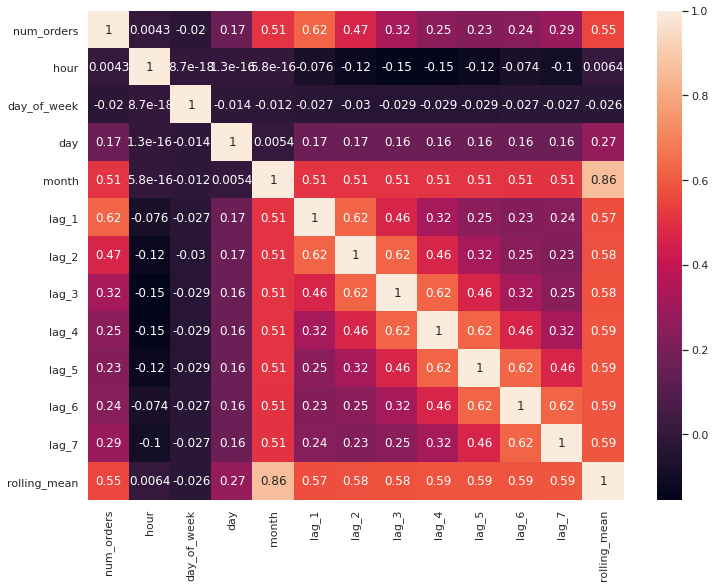

In [ ]:
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(taxi.corr(), annot=True)

* Скользящая средняя сильно коррелирует со вторым лагом. Уберем эти два признака из выборки.
* Количество заказов имеет положительную корреляцию с месяцем, скользящей средней и всеми лагами.

In [ ]:
taxi = taxi.drop(columns=['rolling_mean'], axis=1)
taxi.head()

,num_orders,hour,day_of_week,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN


<AxesSubplot:>

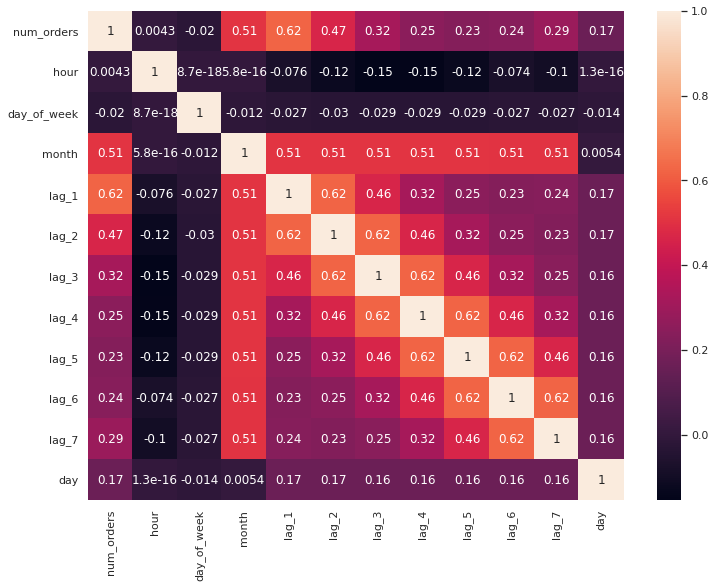

In [ ]:
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(taxi.corr(), annot=True)

* Сильный корреляций между признаками не обнаружено. 
* Данные подготовлены для обучения модели.

## Обучение

### Разделение выборки и выделение признаков.

* Разделим выборку на обучающую и тестовую, где выделим 10% на тестовую часть.
* Посмотрим графически.

Количество наблюдений: 4416
Количество наблюдений в тренировочной выборке: 3974
Количество наблюдений в тествой выборке: 442


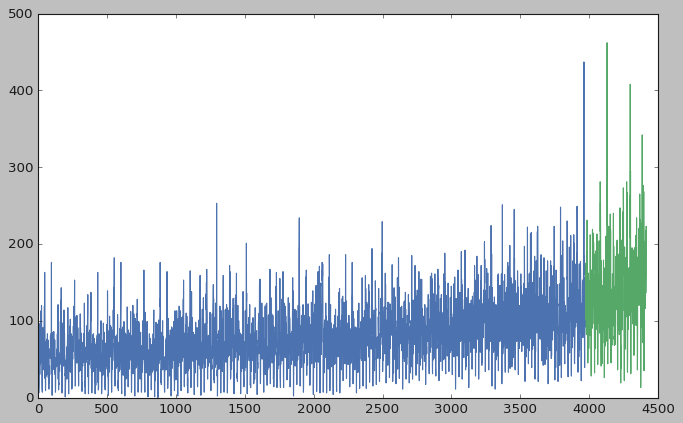

In [ ]:
plt.style.use('classic')
X = taxi['num_orders'].values
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:len(X)]
print('Количество наблюдений:',  (len(X)))
print('Количество наблюдений в тренировочной выборке:', (len(train)))
print('Количество наблюдений в тествой выборке:', (len(test)))
plt.figure(figsize=(10,6))
plt.plot(train)

plt.plot([None for x in train] + [x for x in test])

plt.show()

* В тестовую выборку попадает большая часть данных c большой дисперсией. Однако в самый конец тренировочной выборки так же попало несколько выбросов.

In [ ]:
# Разделим выборку и удалим строки с пропусками в тренировочной выборке
train, test = train_test_split(taxi, test_size=0.1, shuffle=False)
train = train.dropna()

In [ ]:
# Выделим целевой отклик и признаки
y_train = train['num_orders']
X_train = train.drop(['num_orders'], axis=1)

y_test = test['num_orders']
X_test = test.drop(['num_orders'], axis=1)

In [ ]:
train_max = y_train.index[-1]
test_min = y_test.index[0]
print(train_max, test_min)

2018-08-13 13:00:00 2018-08-13 14:00:00


* Выборка разделена адекватно.

### LinearRegression

In [ ]:
# Разделим тренировочную выборку на 20 частей
time_split = TimeSeriesSplit(n_splits=20)

In [ ]:
[(split[0].shape, split[1].shape) for split in time_split.split(X_train)]

[((186,), (181,)),
 ((367,), (181,)),
 ((548,), (181,)),
 ((729,), (181,)),
 ((910,), (181,)),
 ((1091,), (181,)),
 ((1272,), (181,)),
 ((1453,), (181,)),
 ((1634,), (181,)),
 ((1815,), (181,)),
 ((1996,), (181,)),
 ((2177,), (181,)),
 ((2358,), (181,)),
 ((2539,), (181,)),
 ((2720,), (181,)),
 ((2901,), (181,)),
 ((3082,), (181,)),
 ((3263,), (181,)),
 ((3444,), (181,)),
 ((3625,), (181,))]

In [ ]:
X_train.shape

(3950, 12)

In [ ]:
%%time
# Проверим оценку RMSE Линейной регрессии через кросс валидацию
model_lr = LinearRegression()
cv_scores_lr = cross_val_score(model_lr, X_train, y_train, cv=time_split, 
                            scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f'RMSE Линейной регрессии: {round(cv_scores_lr.mean(), 3)}')

RMSE Линейной регрессии: -30.415
CPU times: user 152 ms, sys: 97.8 ms, total: 250 ms
Wall time: 227 ms


* Ожидаемая ошибка 48. RMSE Линейной регрессии на обучающей выборке ниже ожидаемой ошибки. 

### Случайный лес

In [ ]:
%%time

# Параметры поиска
param_grid = {'n_estimators': [50, 100, 500],
               'max_depth': [2, 10, 20, 40, 60]
             }



rf = RandomForestRegressor()

rf_RandomGrid = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = param_grid, 
                                   cv = time_split, 
                                   verbose=500, 
                                   n_jobs = -1,
                                  scoring='neg_root_mean_squared_error')


rf_RandomGrid.fit(X_train, y_train)

print(rf_RandomGrid.best_params_)
print(rf_RandomGrid.best_score_)
print(rf_RandomGrid.best_estimator_)


Fitting 20 folds for each of 10 candidates, totalling 200 fits
[CV 1/20; 1/10] START max_depth=10, n_estimators=100............................
[CV 1/20; 1/10] END ..........max_depth=10, n_estimators=100; total time=   0.3s
[CV 2/20; 1/10] START max_depth=10, n_estimators=100............................
[CV 2/20; 1/10] END ..........max_depth=10, n_estimators=100; total time=   0.2s
[CV 3/20; 1/10] START max_depth=10, n_estimators=100............................
[CV 3/20; 1/10] END ..........max_depth=10, n_estimators=100; total time=   0.3s
[CV 4/20; 1/10] START max_depth=10, n_estimators=100............................
[CV 4/20; 1/10] END ..........max_depth=10, n_estimators=100; total time=   0.5s
[CV 5/20; 1/10] START max_depth=10, n_estimators=100............................
[CV 5/20; 1/10] END ..........max_depth=10, n_estimators=100; total time=   0.4s
[CV 6/20; 1/10] START max_depth=10, n_estimators=100............................
[CV 6/20; 1/10] END ..........max_depth=10, n_

* Случайный лес с параметрами в районе глубины 40 на 500 деревьев показывает оценку RMSE лучше, чем у Регрессии.

### CatBooost

* Используем теперь бустинг модель.

In [ ]:
# Создадим список с категориальными признаки.
categorical_features = ['month', 'day', 'day_of_week', 'hour']

In [ ]:
%%time
model_cb = CatBoostRegressor()

params = {'learning_rate': [0.03, 0.07, 0.1],
        'depth': [6, 12],
          'iterations':[500, 1000, 1500],
          'metric_period':[20,50],
            'od_wait': [20,30],
            'od_type':['None', 'Iter']
          
          
        
         }

randomized_search_result = model_cb.randomized_search(params,
                                                   Pool(X_train, y_train, cat_features=categorical_features),
                                                   plot=True,
                                                  verbose=100,
                                                  cv=time_split, n_iter=2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 72.6755449	test: 107.1050176	best: 107.1050176 (0)	total: 52.4ms	remaining: 26.2s
20:	learn: 24.4822479	test: 50.5796865	best: 50.5796865 (20)	total: 1.39s	remaining: 31.7s
40:	learn: 18.2169233	test: 43.7607688	best: 43.7607688 (40)	total: 3.36s	remaining: 37.6s
60:	learn: 15.4504068	test: 41.7078367	best: 41.7078367 (60)	total: 5.75s	remaining: 41.4s
80:	learn: 13.7712213	test: 41.3456476	best: 41.3456476 (80)	total: 7.71s	remaining: 39.9s
100:	learn: 12.1521422	test: 41.0874372	best: 41.0874372 (100)	total: 10.2s	remaining: 40.1s
120:	learn: 10.7557683	test: 40.8838870	best: 40.8838870 (120)	total: 12.5s	remaining: 39s
140:	learn: 9.6313533	test: 40.7474411	best: 40.7474411 (140)	total: 14.8s	remaining: 37.7s
160:	learn: 8.7284005	test: 40.6699906	best: 40.6699906 (160)	total: 17s	remaining: 35.8s
180:	learn: 8.0540216	test: 40.6505070	best: 40.6505070 (180)	total: 19.5s	remaining: 34.3s
200:	learn: 7.4446301	test: 40.6211921	best: 40.6211921 (200)	total: 21.8s	remaining: 

50:	learn: 20.2224346	test: 36.4690783	best: 36.4690783 (50)	total: 367ms	remaining: 3.23s
100:	learn: 18.8691670	test: 35.0588210	best: 34.8615141 (92)	total: 668ms	remaining: 2.64s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 34.86151413
bestIteration = 92

1:	loss: 34.8615141	best: 34.8615141 (1)	total: 56.8s	remaining: 0us
Estimating final quality...
Training on fold [0/20]
0:	learn: 57.4923461	test: 61.9550206	best: 61.9550206 (0)	total: 1ms	remaining: 499ms
50:	learn: 16.3609236	test: 21.2447496	best: 21.2447496 (50)	total: 70.3ms	remaining: 619ms
100:	learn: 11.5152827	test: 19.4513922	best: 19.4513922 (100)	total: 156ms	remaining: 618ms

bestTest = 19.40050243
bestIteration = 102

Training on fold [1/20]


0:	learn: 59.6363922	test: 59.0529056	best: 59.0529056 (0)	total: 3.2ms	remaining: 1.6s
50:	learn: 16.5154594	test: 19.2299254	best: 19.2196287 (49)	total: 94.6ms	remaining: 833ms
100:	learn: 13.1835576	test: 18.8468461	best: 18.8468461 (100)	total: 206ms	remaining: 814ms

bestTest = 18.67512736
bestIteration = 118

Training on fold [2/20]
0:	learn: 59.3234217	test: 61.2565544	best: 61.2565544 (0)	total: 2.19ms	remaining: 1.09s
50:	learn: 15.8632066	test: 21.5150164	best: 21.4825947 (49)	total: 109ms	remaining: 963ms
100:	learn: 13.0911452	test: 20.8416964	best: 20.8107553 (98)	total: 245ms	remaining: 967ms

bestTest = 20.66375539
bestIteration = 122

Training on fold [3/20]
0:	learn: 59.7161678	test: 58.4865285	best: 58.4865285 (0)	total: 2.79ms	remaining: 1.39s
50:	learn: 16.6046999	test: 19.7426573	best: 19.7384755 (49)	total: 116ms	remaining: 1.02s
100:	learn: 14.5288548	test: 19.3523635	best: 19.3493150 (99)	total: 251ms	remaining: 992ms

bestTest = 19.29897789
bestIteration = 114

In [ ]:
model_cb.get_best_score()

{'learn': {'RMSE': 15.318683246769035}}

* Модель CatBoost имеет самую низкую оценку из трех обученных моделей.
* Проведем её тестирование.

## Тестирование

* Проведем тестирование лучшей модели.

In [ ]:
# Лучшие гиперпараметры
model_cb.get_params()

{'loss_function': 'RMSE',
 'metric_period': 50,
 'depth': 6,
 'od_wait': 20,
 'iterations': 500,
 'learning_rate': 0.1,
 'od_type': 'Iter'}

In [ ]:
%%time
model_cb = CatBoostRegressor(**model_cb.get_params())


model_cb.fit(
    X_train, y_train,
    cat_features=categorical_features,
    eval_set=(X_test, y_test),
    logging_level='Verbose',  
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 36.9673100	test: 82.0198350	best: 82.0198350 (0)	total: 7.99ms	remaining: 3.99s
50:	learn: 21.6900064	test: 44.3564853	best: 44.3564853 (50)	total: 319ms	remaining: 2.81s
100:	learn: 20.4135109	test: 41.9429426	best: 41.8088870 (90)	total: 638ms	remaining: 2.52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 41.80888696
bestIteration = 90

Shrink model to first 91 iterations.
CPU times: user 703 ms, sys: 38.6 ms, total: 741 ms
Wall time: 1.11 s


* Ошибка `RMSE` ниже, чем заявленный минимум ошибки, значит все гиперапарметры и фичи были выбраны правильно.

* Получим предсказание модели и построим график предсказания модели.

In [ ]:
# Посмотрим на ошибку предсказания
predict_cb = model_cb.predict(X_test)
rmse_cb = np.sqrt(mean_squared_error([y_test], [predict_cb]))
print(f'RMSE модели CatBoost для одного часа {round(rmse_cb, 3)}')

RMSE модели CatBoost для одного часа 41.809


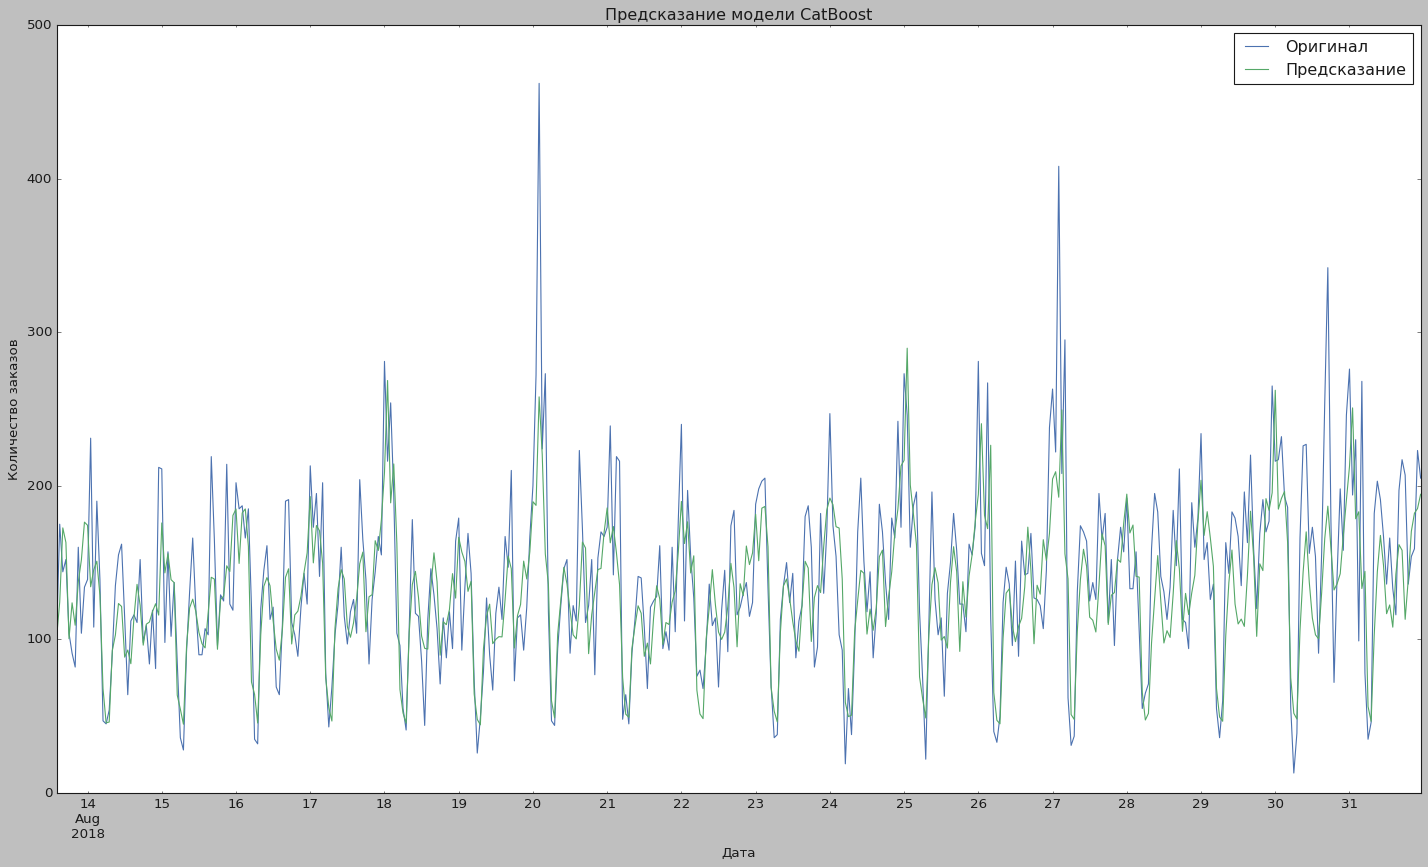

In [ ]:
# Построим график предсказания
plt.style.use('classic')

data=[y_test.values, predict_cb]
(pd.DataFrame(data, columns=y_test.index, index=['Оригинал', 'Предсказание']).T).plot(figsize=(22,12))
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Предсказание модели CatBoost')
plt.show()

* Заметно, что есть ошибки и смещение, тем не менее, основные флуктуации модель предсказывает.
* Посмотрим на важность признаков.

AxesSubplot(0.125,0.1;0.775x0.8)
hour           40.808879
month          22.226316
lag_1           8.763096
lag_2           7.139107
day_of_week     6.296035
lag_7           4.068804
day             3.537256
lag_3           3.312480
lag_4           1.885154
lag_5           1.122366
lag_6           0.840507
dtype: float64


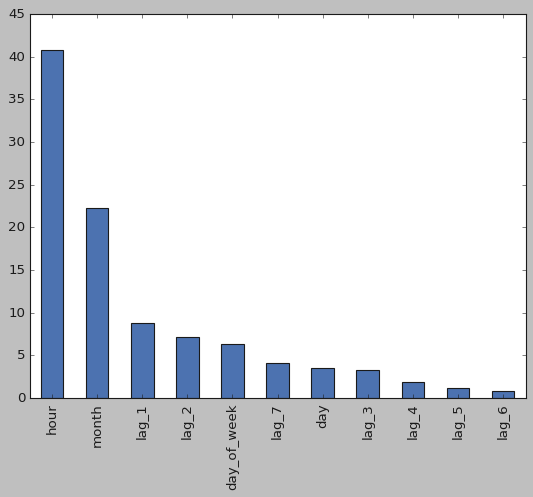

In [ ]:
importances = model_cb.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
print((forest_importances.sort_values(ascending=False)).plot(kind='bar'))
print((forest_importances.sort_values(ascending=False)))
plt.show()

* `Час заказа` оказался самым важным признаком и его значимость оценивается в 40,9%. `Месяц` также является важным признаком.
* Не важными признаками оказались `lag_7`, `day`,  ` lag_3 `,    `lag_4`,       `lag_5`,     `lag_6 ` .
* Возможно их удаление из признаков модели может ещё лучше обучить модель.

### Вывод
* Проведен анализ исторических данных о заказах такси в аэропортах. В данных не обнаружено пропусков и артефактов.
* Созданы признаки для обучения модели. 
* Обучено три модели и выбрана лучшая модель `CatBoost` для тестирования.
* Значение итоговой метрики `RMSE` на тестовой выборке получилось 41.08 заказов для одного часа.